In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, Line, ROICreator
from lib.analysis.align import ImageAlign
from lib.analysis.cell_roi import RandomROISample
from lib.utilities import *

####################################################################################
#    Build a hw vs dist scatter and amp vs dist scatter for all high-SNR px for all
#       of Kate's data
#    Addition:
#       Titrate the size of the ROIs
#          - generate ROI file of random sample of circle ROIs of n_pixels px per ROI
#       Also titrate the SNR cutoff
#          - get more ROI sizes to 20 or 25
#          - plot average of 1-10px ROI sizes for various SNR percentile cutoffs
#          - percentile cutoff should range from 5% to 20%
####################################################################################

In [91]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/"
data_dir = 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/'

enable_photoZ_interaction = False
initialize_photoZ = False
snr_cutoff_signal = 5.0
amp_cutoff = 5.0

snr_cutoffs_titrate = [5 + i for i in range(15)]  # since cutoff is per recording, only whole numbers make sense (there are 100 ROIs/rec/roi_size)
roi_sizes = [i for i in range(1,11)] + [i for i in range(12,21,2)]
create_roi_files = False  # if False, assumes roi files exist

In [3]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ(select=False)

In [15]:
# Generate ROI files of specified sizes
roi_files = []
roi_center_files = []
rfw = ROIFileWriter()
for rsz in roi_sizes:

    # file naming
    filename = data_dir + "ROIs_size_" + str(rsz) + "px.dat"
    roi_files.append(filename)
    ctr_fn = data_dir + "ROIs_centers_" + str(rsz) + "px.dat"
    roi_center_files.append(ctr_fn)
    if create_roi_files:
        roi_sampler = RandomROISample(rsz)

        # return list of lists of pairs (px)
        roi_list = roi_sampler.take_random_sample()
        
        # write centers to file for later use
        roi_center_list = roi_sampler.get_roi_centers()

        with open(ctr_fn, 'w') as f:
            for center in roi_center_list:
                f.write(str(center) + "\n")

        # convert to diode numbers for file writing
        roi_list = ROICreator(None).convert_rois_to_diode_numbers(roi_list)

        # write to file
        rfw.write_regions_to_dat(filename, roi_list)

In [87]:
data_map = {}
is_photoZ_selected = False
# extract all hw and amp files 
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    for zda_file in files:
        if zda_file.endswith('.zda'):
            zda_filepath = subdir + "/" + zda_file
            print(zda_filepath)
            if enable_photoZ_interaction:
                aPhz = AutoPhotoZ(data_dir=subdir)
                # open the PhotoZ file
                if not is_photoZ_selected:
                    aPhz.select_PhotoZ()
                    is_photoZ_selected = True

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(zda_filepath)
                time.sleep(5)

            data_map[subdir] = {}
            for i in range(len(roi_files)):
                roi_file = roi_files[i]
                roi_suffix = "_" + str(roi_sizes[i]) + "px"
                snr_filename = subdir + "/" + "SNR" + roi_suffix + ".dat"
                hw_filename = subdir + "/" + "hw" + roi_suffix + ".dat" 
                amp_filename = subdir + "/" + "amp" + roi_suffix + ".dat"

                data_map[subdir][i] = {"SNR": snr_filename,
                                             "hw": hw_filename,
                                             "amp": amp_filename}

                if all([os.path.exists(x) for x in 
                            [snr_filename, hw_filename, amp_filename]]):
                    continue

                # Open the ROI file 
                if enable_photoZ_interaction:
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_file)
                    time.sleep(5)

                # save SNR values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                # save half-width values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_half_width_trace_value()
                    aPhz.save_trace_values(hw_filename)

                # save latency values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_maxamp_trace_value()
                    aPhz.save_trace_values(amp_filename)


C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-13_02-01-02_L4_intralaminar/02_01_02.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_03-01-08_aka_02-01-08_L23_intralaminar/02_01_08.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_04-01-01_aka_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_06-01-01_aka_part2_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_08-01-04_aka_part2_05-01-04_L4_interlaminar/05_01_04.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_10-01-01_aka_part2_07-01-01_L4_interlaminar/07_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/08_01_06.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-29_04-01-01_L4_interlaminar/04_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2

In [92]:
# for each subdir, take all hw/amp/electrode dist of points with SNR > cutoff
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Diode Number',  'Value'])
    return data_arr

def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr
    
concat_data = pd.DataFrame({})
snr_dfs = []
total_pre_filter = 0
for subdir in data_map:

    # open stim point roi as a single integer (its diode number) in variable stim_pt
    sp_file = subdir + "/" + 'electrode.dat'
    with open(sp_file, 'r') as f:
        lines = f.readlines()
    stim_pt = int(lines[-1]) # last line is always electrode location
    aux_obj = LaminarROI([stim_pt]).get_points()
    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
    
    for i in range(len(roi_sizes)):
        roi_size = roi_sizes[i]
        if roi_size not in data_map[subdir]:
            continue
        dm = data_map[subdir][roi_size]

        # read in data files if they exist
        try:
            amp = read_dat_trace_file(dm['amp'])
            hw = read_dat_trace_file(dm['hw'])
            snr = read_dat_trace_file(dm['SNR'])
        except Exception as e:
            print(e)
            continue
            
        total_pre_filter += len(amp['Value'])
            
        snr = snr.join(amp, rsuffix='amp')
        snr = snr.join(hw, rsuffix='hw')

        # Find distance from diode number to stim_pt
        roi_center_filename = roi_center_files[i]
        with open(roi_center_filename, 'r') as f:
            lines = f.readlines()
        centers_split = [x.strip("[]\n").split(', ')
                             for x in lines]
        centers = [[int(y[0]), int(y[1])] for y in centers_split]
        dist = []
        for ctr_px in centers:
            d = Line(stim_pt, ctr_px).get_length()
            dist.append(d * 6)  # convert px -> um

        snr.insert(4, 'electrode_dist', dist)
        roi_size_col = [roi_size for _ in dist]
        snr.insert(5, 'roi_size', roi_size_col)

        # now some filtering
        snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
        snr = snr[snr['Value'] > snr_cutoff_signal]

        snr = snr[snr['Valuehw'] > 0]
        snr = snr[snr['Valuehw'] < 15]
        snr = snr[snr['Valueamp'] > amp_cutoff]

        snr_dfs.append(snr)

all_snr = pd.concat(snr_dfs)
print(total_pre_filter)
all_snr = all_snr[all_snr['electrode_dist'] > 100]
all_snr

[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/amp_20px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/SNR_5px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/amp_20px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-03-09_03-01-02_L5_interlaminar/amp_20px.dat'
61900


,Diode Number,Value,Diode Numberamp,Valueamp,electrode_dist,roi_size,Diode Numberhw,Valuehw
73,74,6.98349,74,5.24026,325.219926,8,74,3.02831
5,6,5.49952,6,5.28374,120.000000,1,6,3.57054
11,12,8.09528,12,6.61424,234.000000,1,12,7.80747
68,69,8.50250,69,5.98882,235.227549,1,69,4.53694
9,10,5.94158,10,5.95624,368.401954,2,10,5.42499
...,...,...,...,...,...,...,...,...
92,93,5.27719,93,31.57940,144.499135,7,93,5.90508
8,9,11.21090,9,5.29134,438.657041,9,9,2.65423
67,68,10.68040,68,5.35668,170.762994,10,68,2.62489
84,85,5.51950,85,7.86290,353.643889,12,85,3.62149


Num points: 351
[-1.48748876e-04  5.45080938e+00]
r^2 = 4.7107167156223536e-05


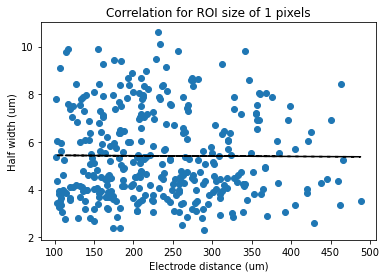

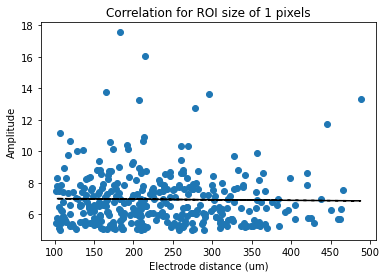

r^2 = 0.00032817319729523637
Num points: 408
[-5.36659712e-05  5.16277235e+00]
r^2 = 5.933781375496343e-06


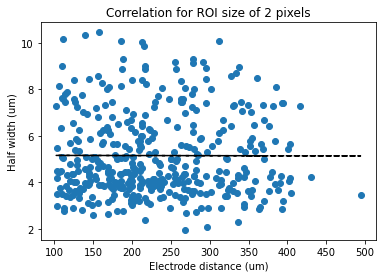

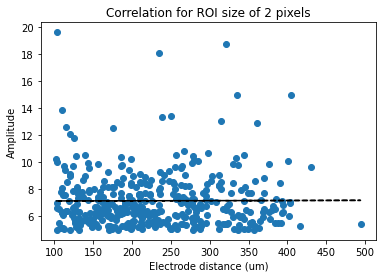

r^2 = 1.7012227414774538e-05
Num points: 409
[-3.28993392e-03  5.82551682e+00]
r^2 = 0.02386634897093831


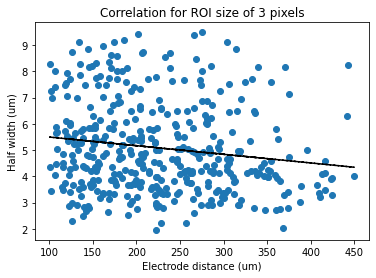

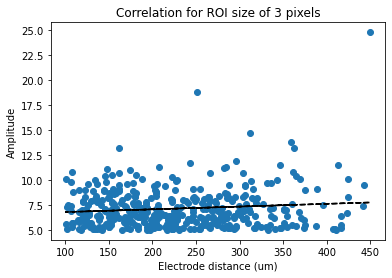

r^2 = 0.011921808786268487
Num points: 361
[-1.12285470e-03  5.43378881e+00]
r^2 = 0.002397699408214386


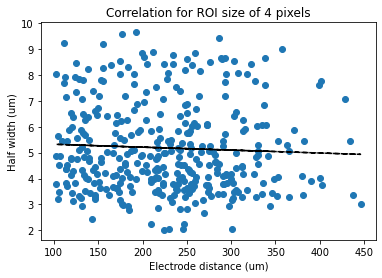

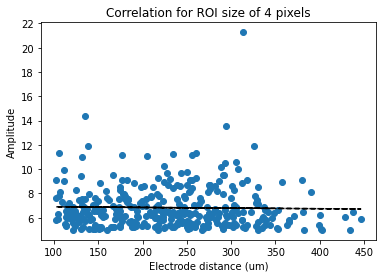

r^2 = 0.0005241895459243415
Num points: 408
[-1.56844473e-03  5.56367406e+00]
r^2 = 0.004778518777640909


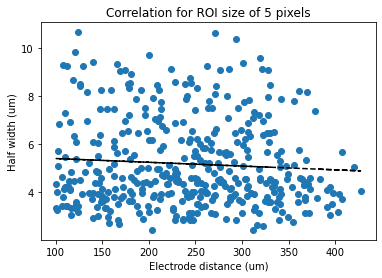

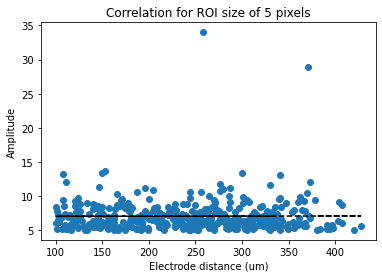

r^2 = 2.5982798923430358e-05
Num points: 361
[3.43116632e-04 5.25789784e+00]
r^2 = 0.0002354136415632122


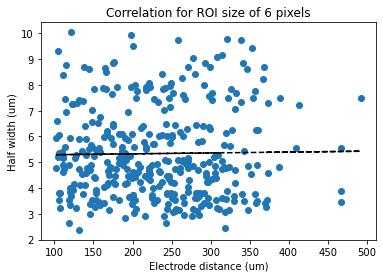

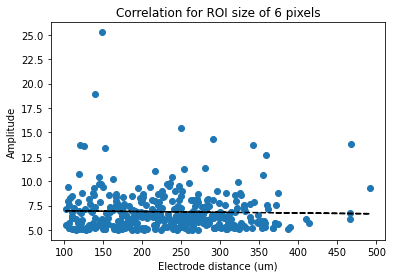

r^2 = 0.0008031285886409722
Num points: 395
[-3.40719140e-03  5.93719614e+00]
r^2 = 0.025232742559431712


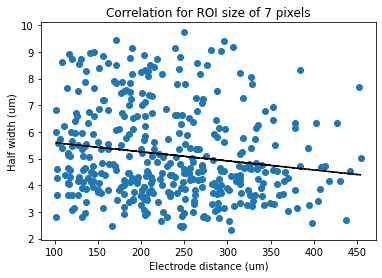

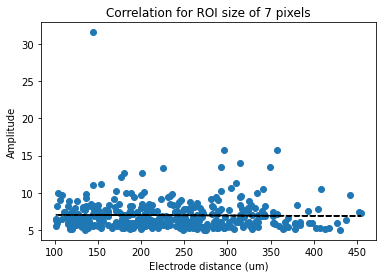

r^2 = 0.0002573954292930845
Num points: 371
[9.20130709e-05 5.23615561e+00]
r^2 = 1.8179754338970455e-05


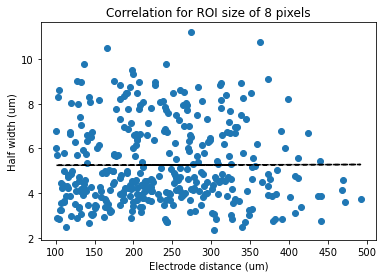

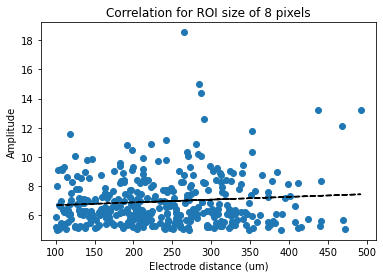

r^2 = 0.008386776430019399
Num points: 360
[-1.25259854e-03  5.67784680e+00]
r^2 = 0.003111551048788643


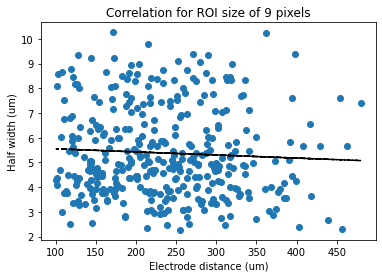

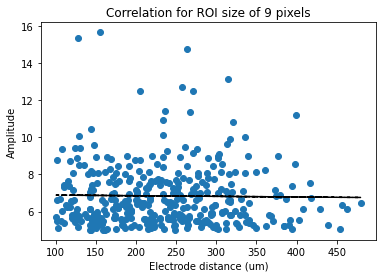

r^2 = 0.00025872114937145163
Num points: 372
[-6.98711067e-04  5.34769466e+00]
r^2 = 0.0009823826307399724


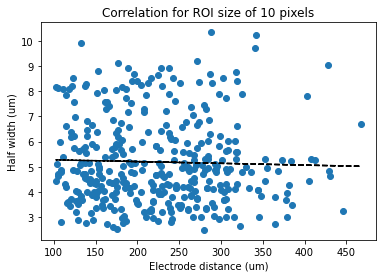

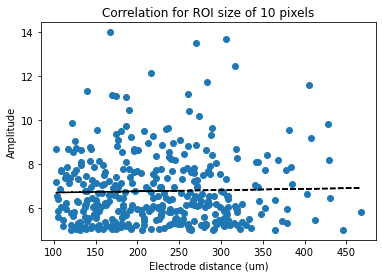

r^2 = 0.0007075070409983702
Num points: 398
[-1.16293514e-03  5.49044642e+00]
r^2 = 0.0026619090916309798


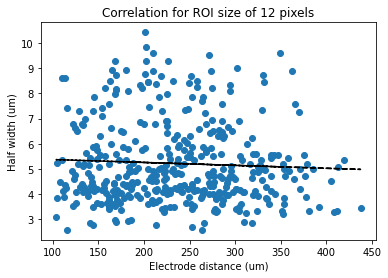

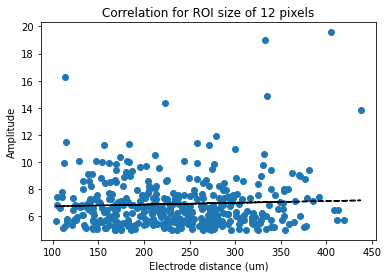

r^2 = 0.0025324899146519104
Num points: 345
[-1.75969743e-03  5.67994730e+00]
r^2 = 0.00582315667606697


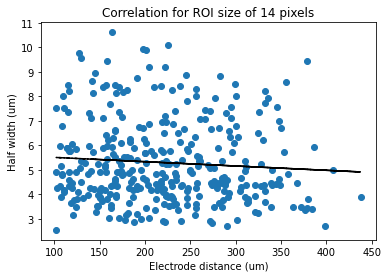

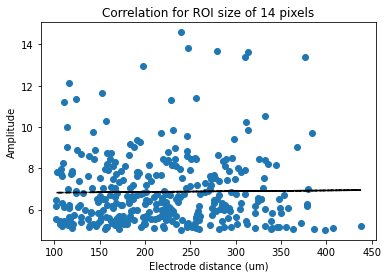

r^2 = 0.00022636305669459467
Num points: 0
Num points: 0
Num points: 0


In [93]:
#  BY ROI_SIZE now
slopes = {
    'amp': [],
    'hw': [],
    'r_amp': [],
    'r_hw': [],
    'roi_sizes': [],
    'num_points': []
}
for roi_size in roi_sizes:
    
    df_rs = all_snr[all_snr['roi_size'] == roi_size]
    print("Num points:", len(df_rs['electrode_dist']))
    if len(df_rs['electrode_dist']) < 1:
        continue
    slopes['num_points'].append(len(df_rs['electrode_dist']))
    
    # scatter plot: hw vs electrode dist 
    x = df_rs['electrode_dist']
    plt.scatter(x, df_rs['Valuehw'])
    coef = np.polyfit(x, df_rs['Valuehw'], 1)
    print(coef)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, df_rs['Valuehw'])[0,1]

     # r
    print("r^2 =", correlation**2)
    slopes['r_hw'].append(correlation**2)
    plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[0])[5])
    plt.xlabel("Electrode distance (um)")
    plt.ylabel("Half width (um)")
    plt.title("Correlation for ROI size of " + str(roi_size)
             + " pixels")
    plt.show()
    
    slopes['hw'].append(correlation)
    
    ### scatter plot: amp vs electrode dist
    plt.scatter(x, df_rs['Valueamp'])
    coef = np.polyfit(x, df_rs['Valueamp'], 1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[0])[5])
    plt.xlabel("Electrode distance (um)")
    plt.ylabel("Amplitude")
    plt.title("Correlation for ROI size of " + str(roi_size)
             + " pixels")
    plt.show()
    
    correlation = np.corrcoef(x, df_rs['Valueamp'])[0,1]

     # r
    print("r^2 =", correlation**2)
    slopes['r_amp'].append(correlation**2)
    
    slopes['amp'].append(correlation)
    slopes['roi_sizes'].append(roi_size)
    
    

num points: [351, 408, 409, 361, 408, 361, 395, 371, 360, 372, 398, 345] 4539
[-0.018115551255626652, 0.004124588150927864, 0.10918703579760963, -0.022895186086257117, 0.005097332530199531, -0.02833952343708292, -0.01604354790229033, 0.0915793449966716, -0.01608481113881825, 0.02659900451141678, 0.05032385035598837, 0.015045366618816395]
[-0.0068634661182396415, -0.0024359354210439044, -0.15448737479463592, -0.04896630890943676, -0.06912683109792397, 0.015343195285311733, -0.15884817455492434, 0.004263772313218713, -0.05578127865860232, -0.03134298375617695, -0.051593692362836174, -0.07630961064025271]


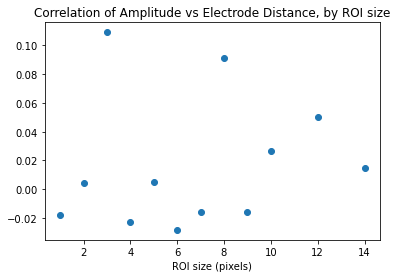

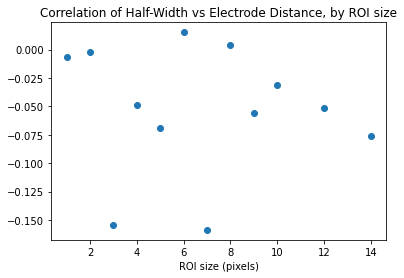

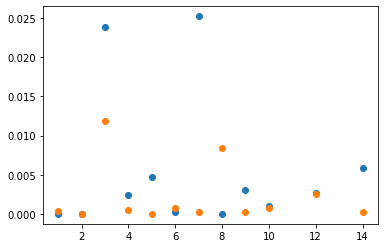

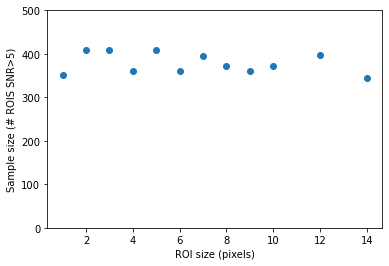

In [94]:
# plot the slopes vs roi_sizes
print("num points:", 
      slopes['num_points'],
      sum( slopes['num_points']))

plt.clf()
print(slopes['amp'])
print(slopes['hw'])
plt.scatter(slopes['roi_sizes'], slopes['amp'])
plt.xlabel('ROI size (pixels)')
plt.title('Correlation of Amplitude vs Electrode Distance, by ROI size')
plt.show()

plt.scatter(slopes['roi_sizes'], slopes['hw'])
plt.xlabel('ROI size (pixels)')
plt.title('Correlation of Half-Width vs Electrode Distance, by ROI size')
plt.show()

plt.scatter(slopes['roi_sizes'], slopes['r_hw'])
plt.scatter(slopes['roi_sizes'], slopes['r_amp'])
plt.show()

plt.scatter(slopes['roi_sizes'], slopes['num_points'])
plt.ylim([0,500])
plt.xlabel('ROI size (pixels)')
plt.ylabel("Sample size (# ROIS SNR>5)")
plt.show()

In [ ]:
for snr_cutoff_percentile in snr_cutoffs_titrate:
    snr_cutoff_percentile /= 100
    